In [1]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D, Conv2D, Flatten, Dense, Reshape
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
from keras import initializers
import keras

import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os import system
import os
import random

import imageio

from skimage.measure import block_reduce

Using TensorFlow backend.


In [2]:
brief_patch_size = 48  # default value of PATCH_SIZE in OpenCV implementation
input_patch_size = 56  # larger than the default value, s.t. the blurring is done using valid padding

nb_epoch = 50
batch_size = 32

averaging_kernel_weight_9x9 = 1./81
averaging_kernel_weight_5x5 = 1./25
averaging_kernel_weight_3x3 = 1./9

weights_dense = np.load("./weights/weights_dense_64.npy")

In [3]:
base_dir = '/scratch/image_datasets/2_for_learned_brief/ready'

train_data_dir      = base_dir + '/train'
validation_data_dir = base_dir + '/validation'
test_data_dir       = base_dir + '/test'

train_descrs_dir      = base_dir + '/train'
validation_descrs_dir = base_dir + '/validation'
test_descrs_dir       = base_dir + '/test'

In [4]:
def loading_data(dir_patches, dir_descrs):
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    patches_in = []
    patches_out = []

    
    for file_patch in files_patches:
        patch_in = imageio.imread(dir_patches + '/class0/' + file_patch)
        
        patch_out = patch_in[5: 53, 5: 53]
        patch_out = block_reduce(patch_out, (4, 4), func=np.mean)
        
        patches_in.append(patch_in)
        patches_out.append(patch_out)
        

    patches_in = np.array(patches_in)
    patches_in = patches_in.astype(np.float64) / 255
    
    patches_out = np.array(patches_out)
    patches_out = patches_out.astype(np.float64) / 255
    
    print("in", patches_in.shape, "  out", patches_out.shape)
    
    return patches_in, patches_out

In [5]:
x_train, y_train = loading_data(train_data_dir, train_descrs_dir)
x_validation, y_validation = loading_data(validation_data_dir, validation_descrs_dir)

in (64598, 56, 56)   out (64598, 12, 12)
in (8075, 56, 56)   out (8075, 12, 12)


In [6]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))

x_validation = x_validation.reshape((x_validation.shape[0], x_validation.shape[1], x_validation.shape[2], 1))
y_validation = y_validation.reshape((y_validation.shape[0], y_validation.shape[1], y_validation.shape[2], 1))
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)

(64598, 56, 56, 1) (64598, 12, 12, 1)
(8075, 56, 56, 1) (8075, 12, 12, 1)


In [7]:
def fixed_generator(x_train, y_train, batch_size):
    while True:
        batch_list_x = []
        batch_list_y = []
        
        for i in range(x_train.shape[0]):
            batch_list_x.append(x_train[i])
            batch_list_y.append(y_train[i])
            if len(batch_list_x) == batch_size:
                yield (np.array(batch_list_x),np.array(batch_list_y))
                batch_list_x = []
                batch_list_y = []

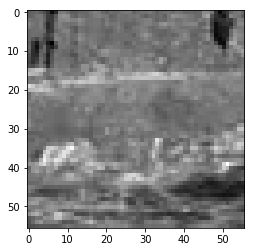

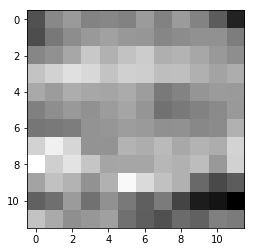

In [8]:
plt.imshow(x_train[3, :, :, 0], cmap='gray')
plt.show()
plt.imshow(y_train[3, :, :, 0], cmap='gray')
plt.show()

In [16]:
# my_adadelta = keras.optimizers.Adadelta(learning_rate=0.1, rho=0.95)

In [9]:
input_shape = (input_patch_size, input_patch_size, 1)
input_img = Input(shape=input_shape)

x = Conv2D(1, (3,3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(input_img)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
x = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
average_blurred = Conv2D(1, (3, 3), activation="relu", padding="valid", kernel_initializer=initializers.Constant(averaging_kernel_weight_3x3), bias_initializer=keras.initializers.Zeros())(x)
flattened = Flatten(data_format="channels_last")(average_blurred)
briefed = Dense(weights_dense.shape[1], activation="sigmoid", weights=[weights_dense, np.zeros(weights_dense.shape[1])])(flattened)


x = Dense(1152, activation="relu")(briefed)
x = Reshape((6, 6, 32))(x)

x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = Conv2D(8, (3,3), activation="relu", padding="same")(x)
decoded = Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

brief_ae = Model(input_img, decoded)

brief_ae.compile(optimizer="adadelta", loss="binary_crossentropy")
brief_ae.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 56, 56, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 54, 54, 1)         10        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 1)         10        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 1)         10        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 48, 48, 1)         10        
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1180

In [11]:
# from keras.callbacks import Callback

# # taken from https://github.com/keras-team/keras/issues/7874#issuecomment-329347949

# class LRPrintCallback(Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         lr = self.model.optimizer.lr
#         decay = self.model.optimizer.decay
#         iterations = self.model.optimizer.iterations
#         lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
#         print(K.eval(lr_with_decay))
#         print(K.eval(lr))
#         print(K.eval(decay))
        
# lr_printer = LRPrintCallback()

In [10]:
model_version_previous = '0.0.2.0.0_decoder_dense1152_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output12x12'
brief_ae_previous = load_model(base_dir + '/brief_ae_' + model_version_previous + '.h5')

In [11]:
brief_ae_previous.get_layer(index=7).get_weights()[0].shape

(512, 1152)

In [12]:
for i in range(7, len(brief_ae.layers)):
    print(brief_ae_previous.get_layer(index=i))
    brief_ae.get_layer(index=i).set_weights(brief_ae_previous.get_layer(index=i).get_weights())

In [13]:
model_version = '0.0.2.0.0_whole_dense1152_conv32_conv32_up_conv32_conv8_conv1__relu_last_sigmoid_bce_output12x12'

os.system('mkdir ' + base_dir + '/weights' + model_version)

checkpointer = keras.callbacks.ModelCheckpoint(
    base_dir + '/weights' + model_version + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss',
    verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# brief_ae.fit_generator(fixed_generator(x_train, y_train, batch_size),
#                 steps_per_epoch=x_train.shape[0],
#                 epochs=50,
#                 validation_data=fixed_generator(x_validation, y_validation, batch_size),
#                 validation_steps=x_validation.shape[0]#,
#                 callbacks=[checkpointer]
#                 )

# brief_ae.save(base_dir + '/brief_ae_' + model_version + '.h5')

brief_ae = load_model(base_dir + '/brief_ae_' + model_version + '.h5')

predictions: 


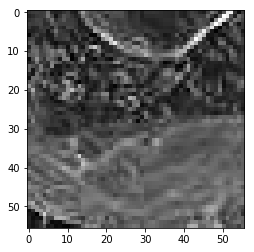

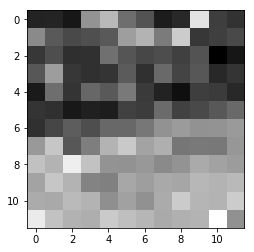

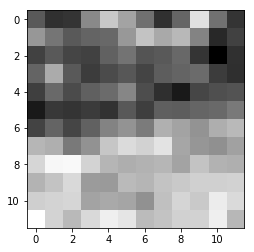

9.507278893142939

 next


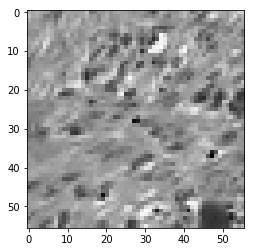

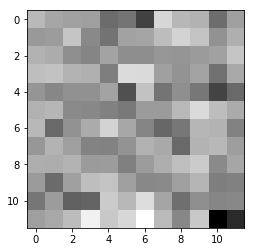

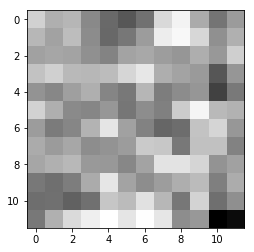

11.109694708138704

 next


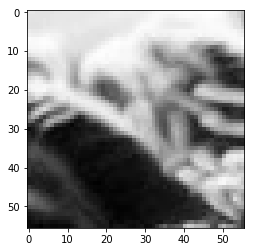

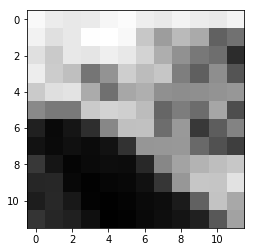

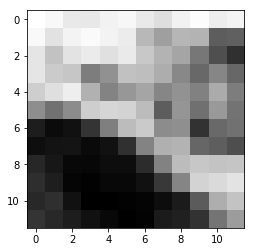

15.741664208471775

 next


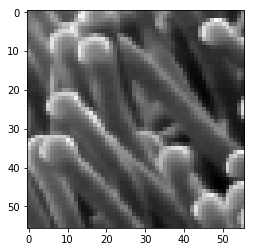

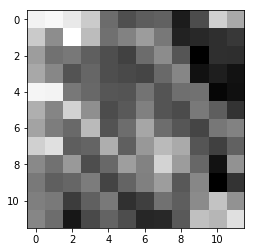

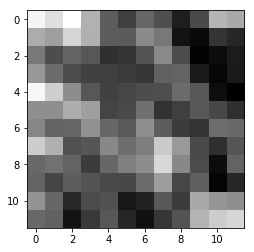

8.674448132514954

 next


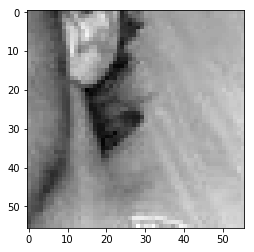

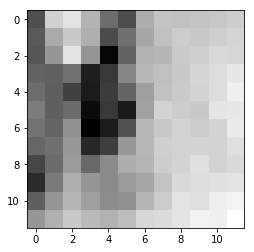

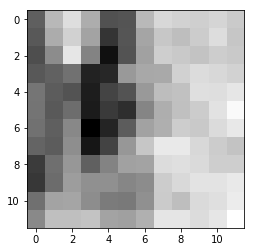

6.606288459151983

 next


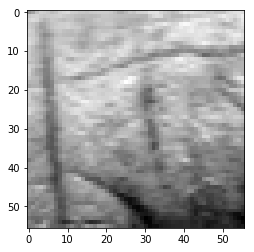

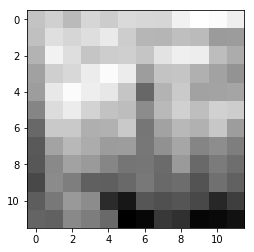

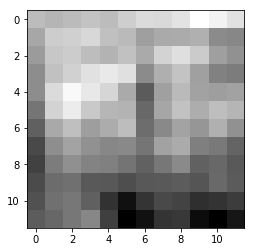

7.202615635469556

 next


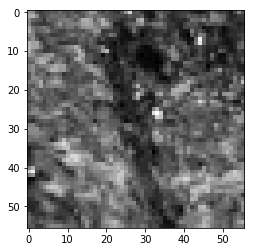

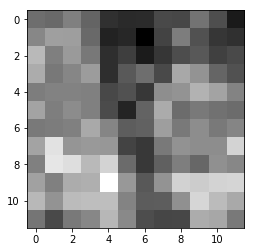

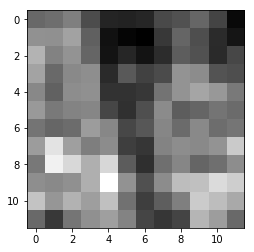

9.269892331212759

 next


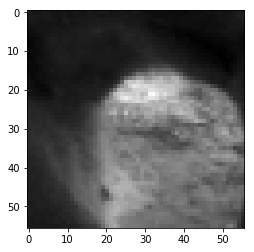

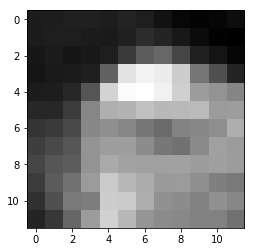

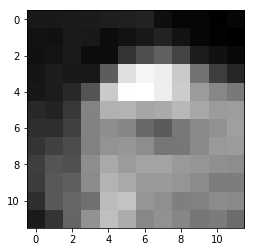

7.496043965220451

 next


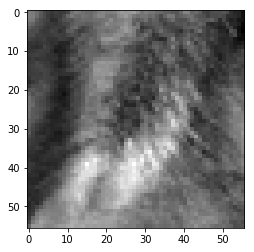

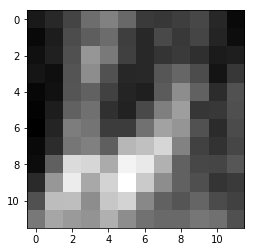

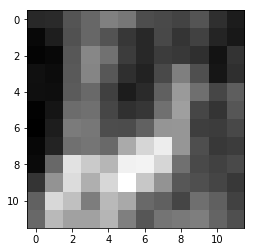

6.532157761976123

 next


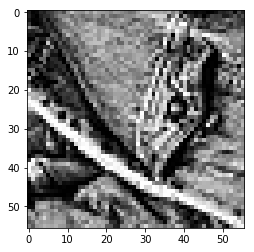

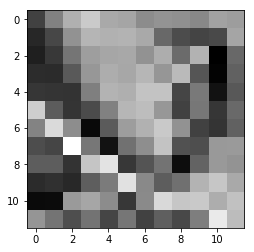

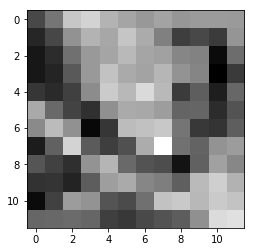

21.116796880960464

 next


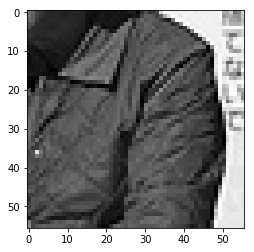

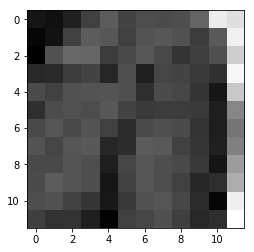

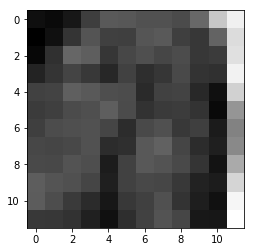

11.709985546767712

 next


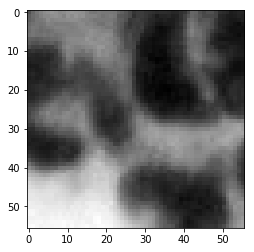

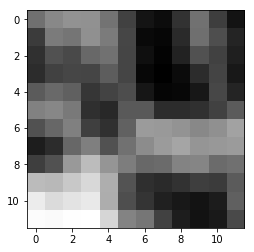

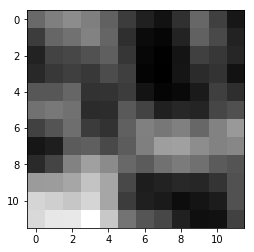

6.470879400148988

 next


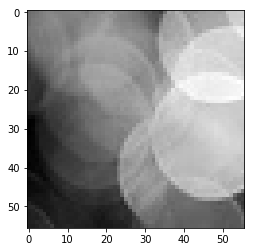

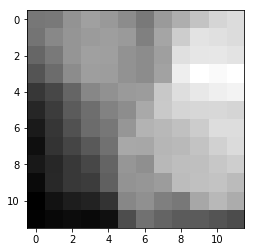

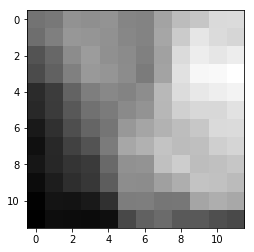

9.550324883311987

 next


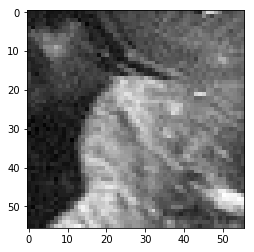

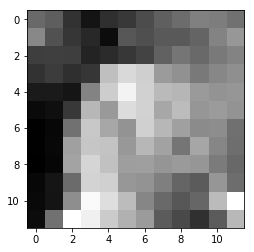

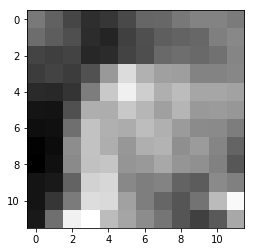

7.217433890327811

 next


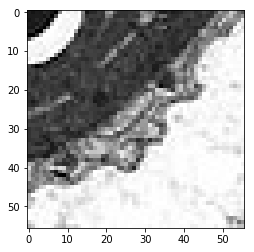

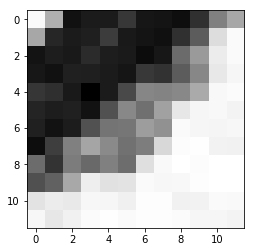

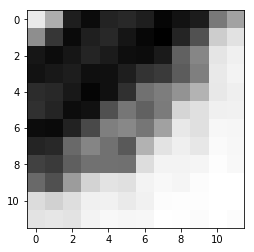

14.317428432404995

 next


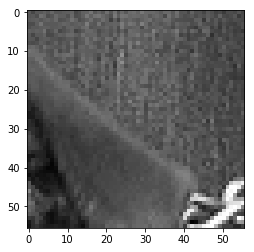

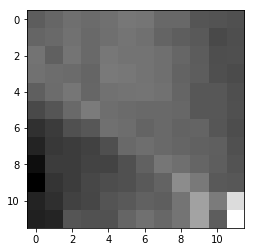

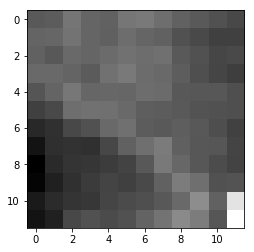

7.910730438306928

 next


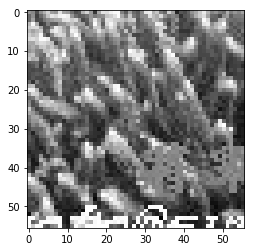

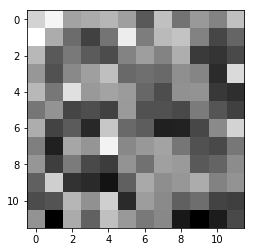

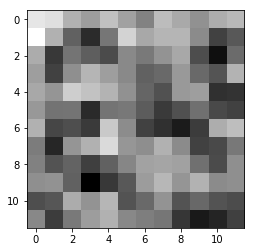

13.981649950146675

 next


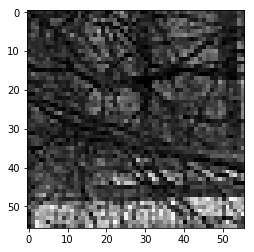

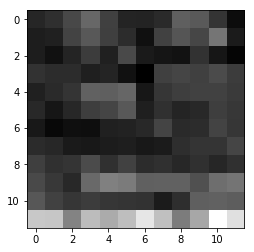

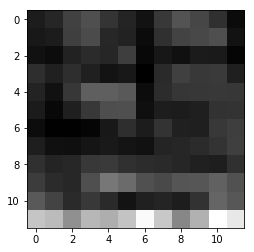

9.748575445264578

 next


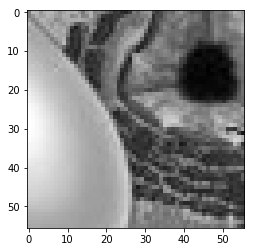

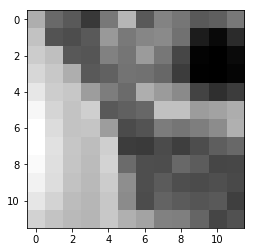

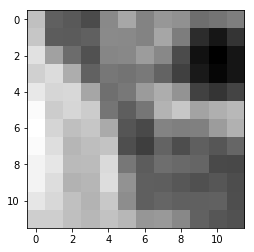

10.866015683859587

 next


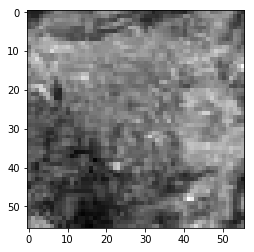

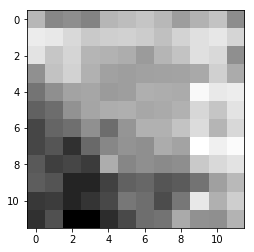

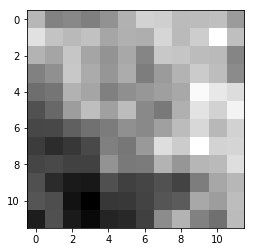

6.435275310650468

 next


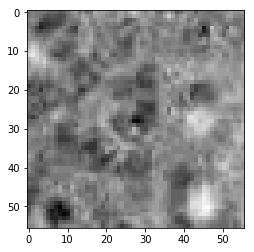

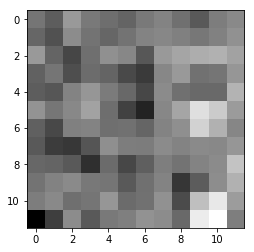

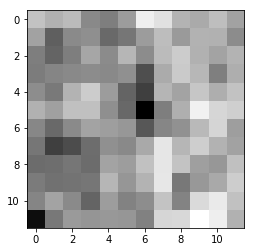

10.051652882248163

 next


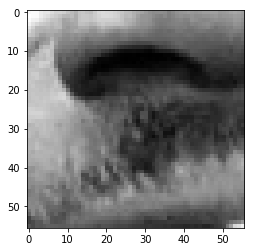

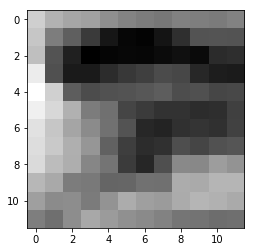

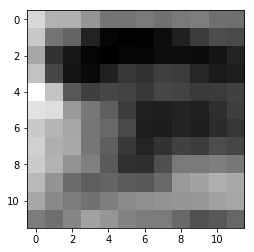

8.368881829082966

 next


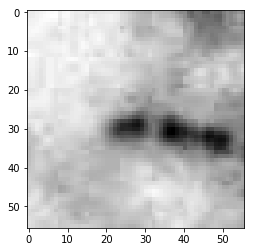

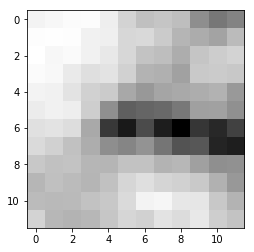

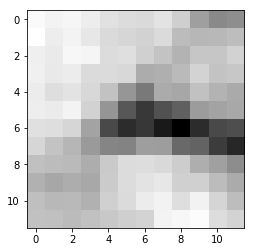

10.508081540465355

 next


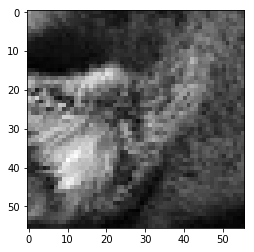

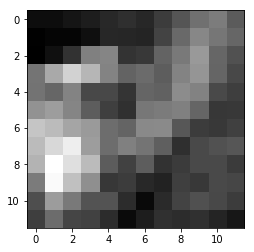

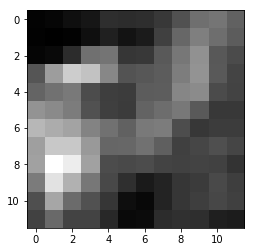

8.444018997251987

 next


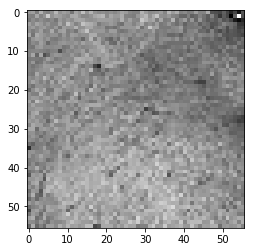

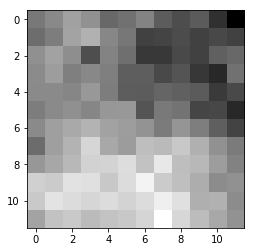

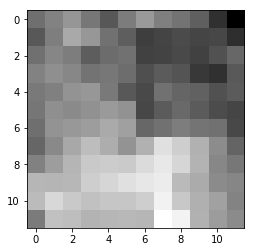

9.07993197441101

 next


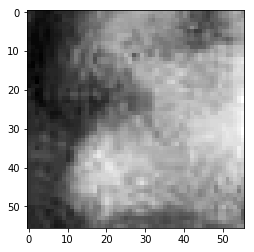

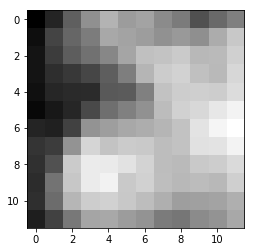

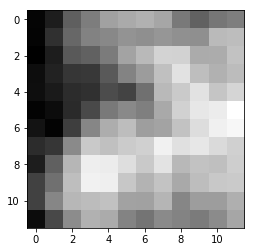

6.547354571521282

 next


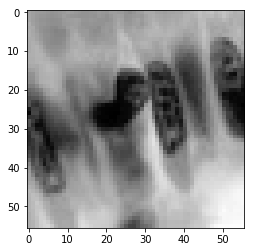

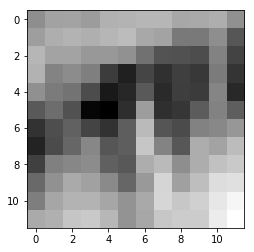

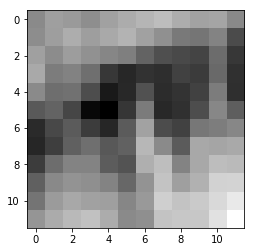

10.348356161266565

 next


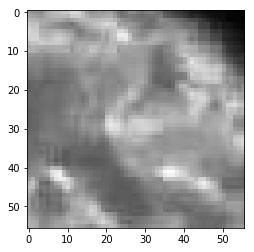

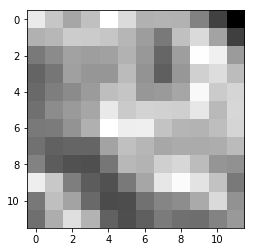

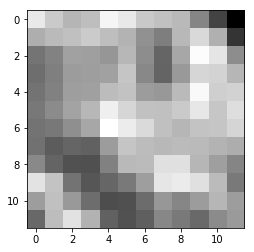

7.099753255024552

 next


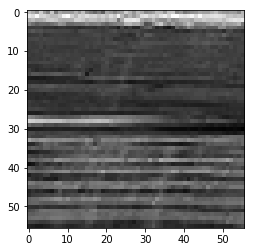

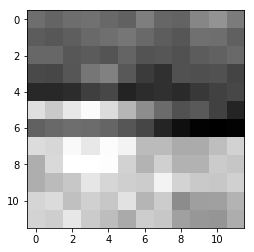

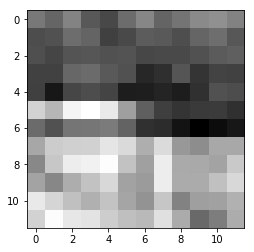

7.5082422606647015

 next


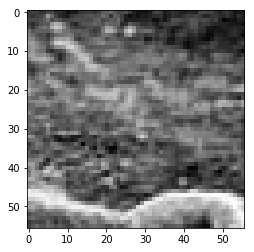

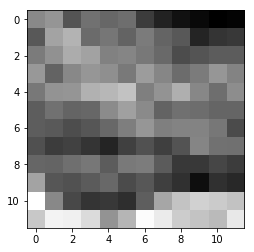

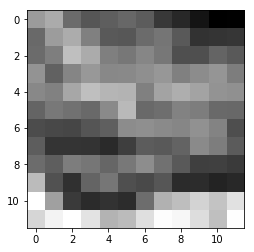

10.877907145768404

 next


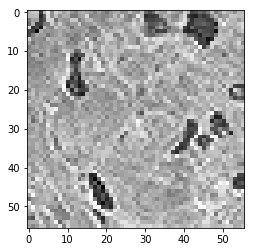

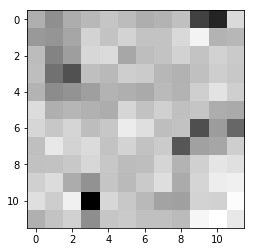

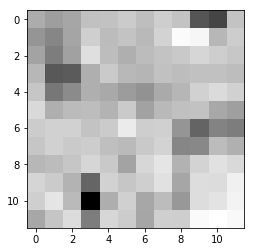

11.935287807136774

 next


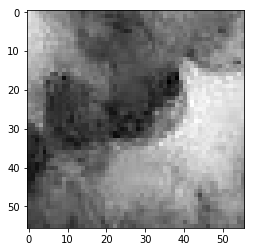

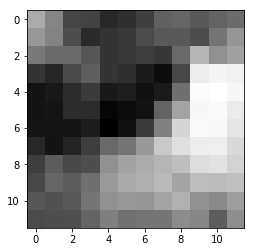

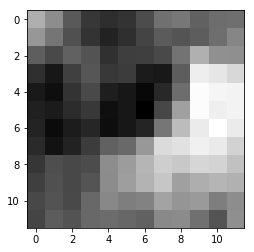

7.281099949032068

 next


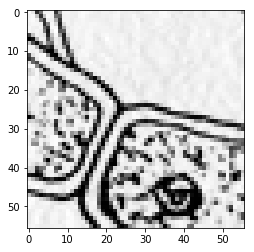

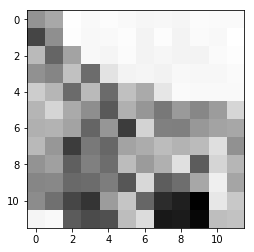

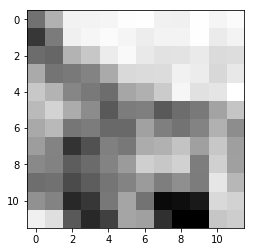

20.138387382030487

 next


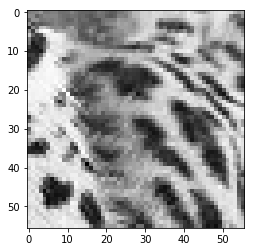

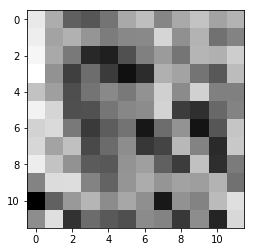

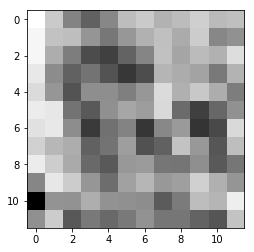

17.137405313551426

 next


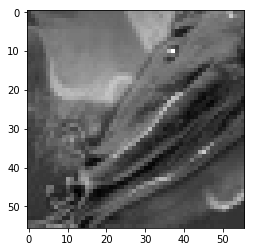

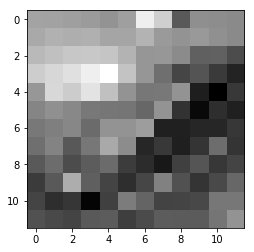

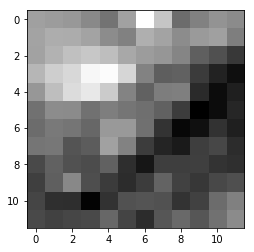

9.613580089062452

 next


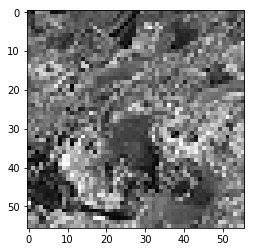

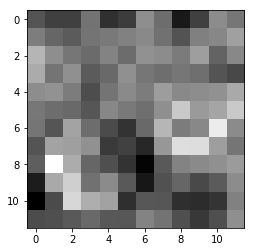

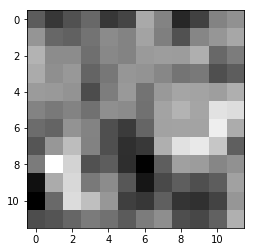

11.639616172760725

 next


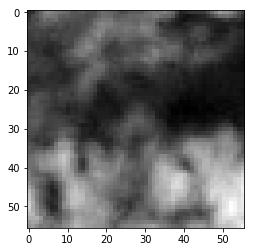

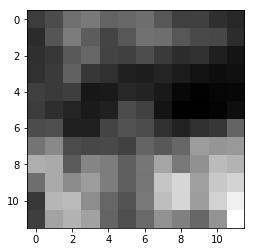

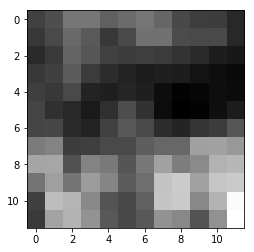

9.03507063165307

 next


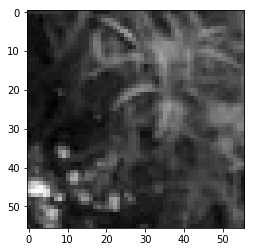

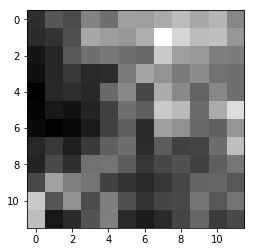

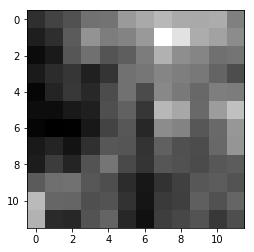

7.776630884036422

 next


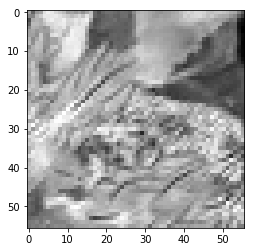

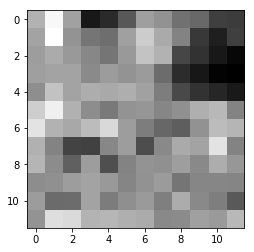

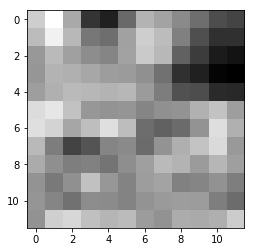

11.618989929556847

 next


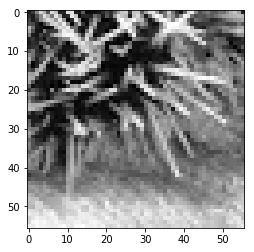

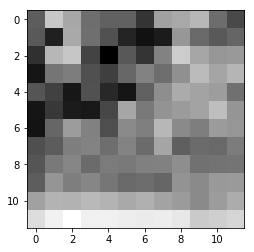

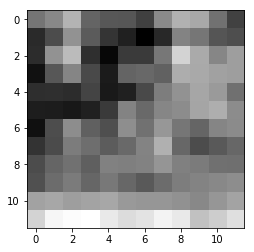

16.056388020515442

 next


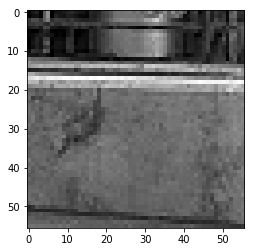

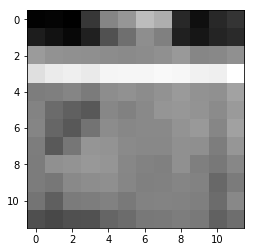

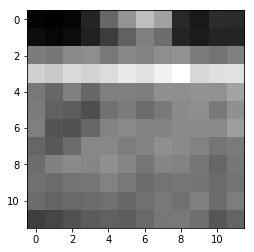

7.749584410339594

 next


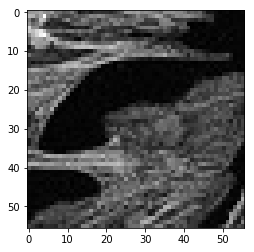

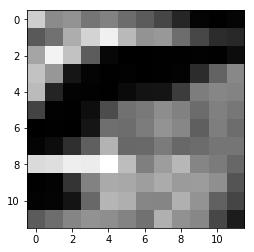

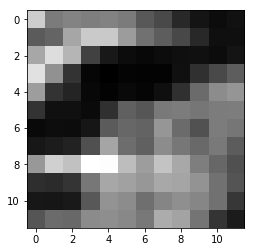

8.457301184535027

 next


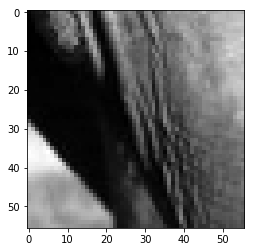

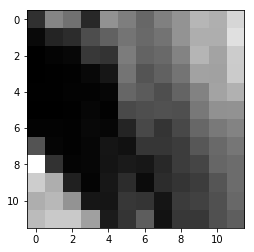

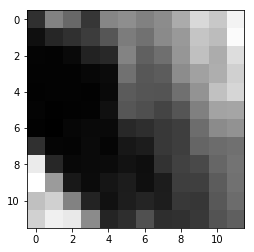

10.547121595591307

 next


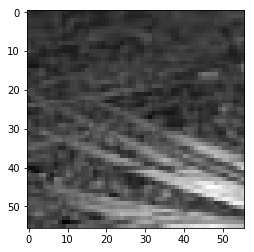

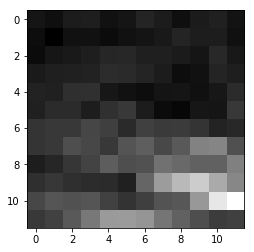

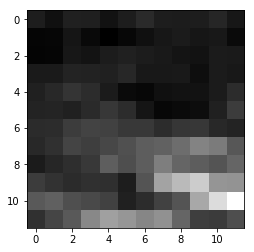

8.19990299642086

 next


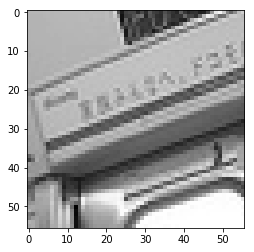

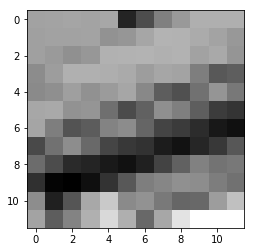

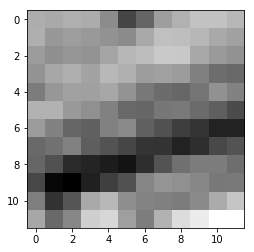

13.601507898420095

 next


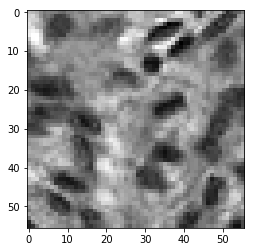

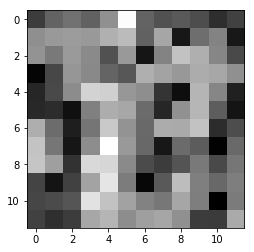

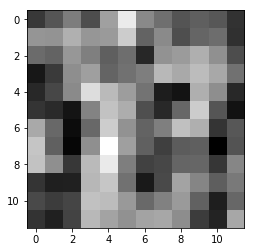

10.326882563531399

 next


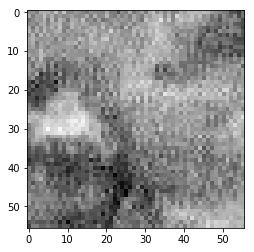

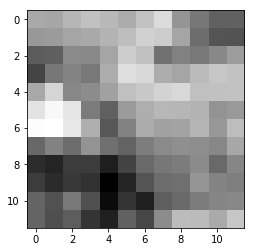

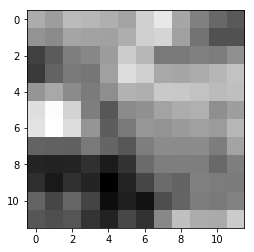

10.248827151954174

 next


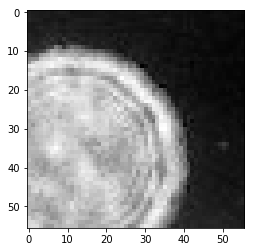

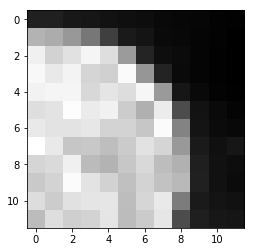

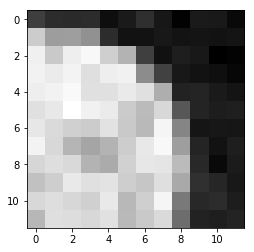

9.937829989939928

 next


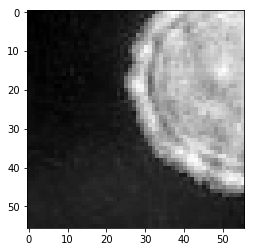

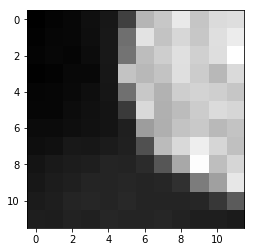

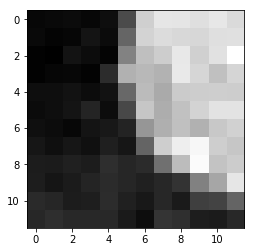

8.279080297797918

 next


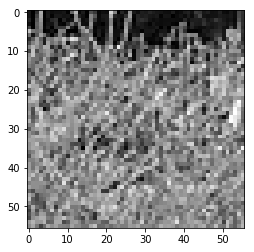

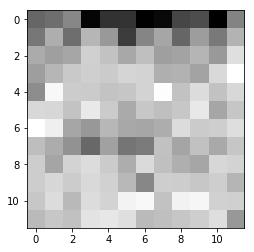

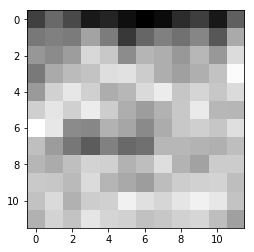

10.182004887610674

 next


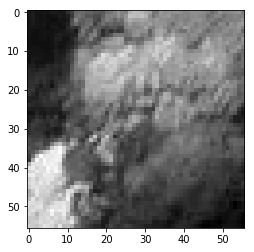

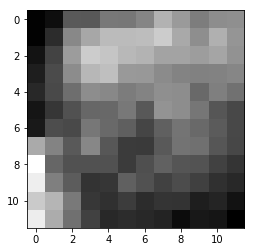

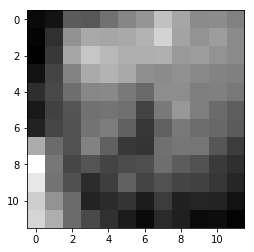

7.862735688686371

 next


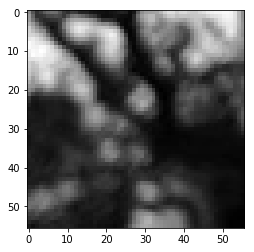

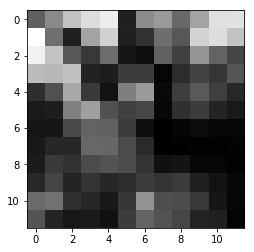

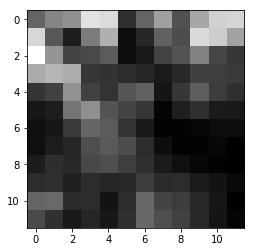

10.280928779393435

 next


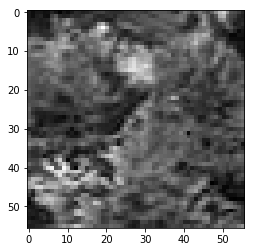

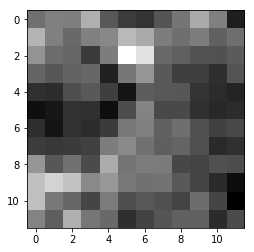

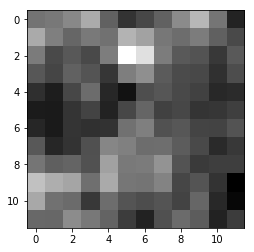

9.531009569764137

 next


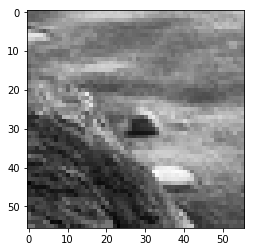

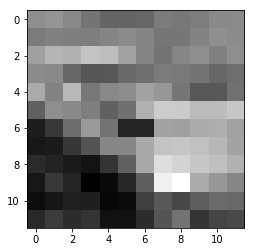

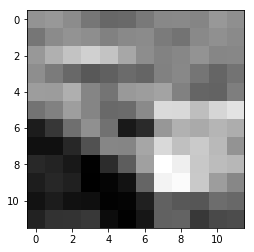

9.671962056308985

 next


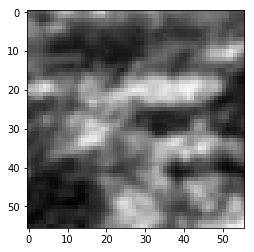

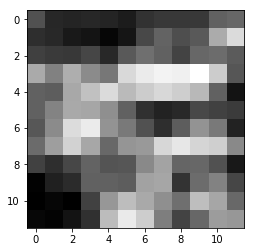

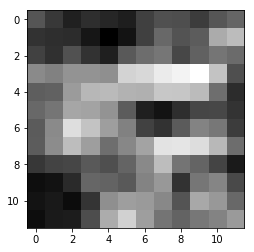

8.250276893377304

 next


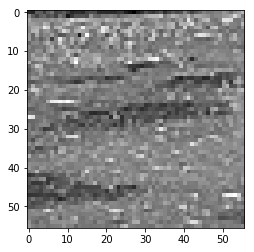

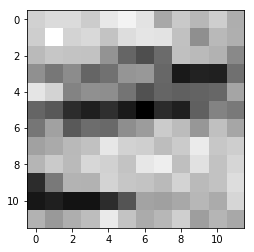

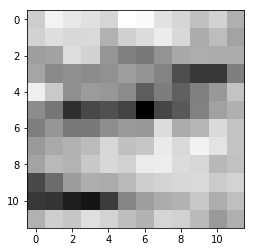

8.955204617232084

 next


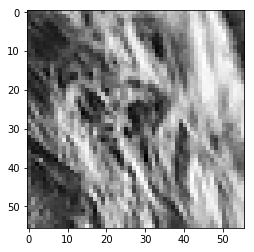

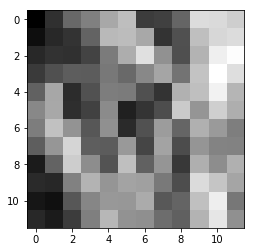

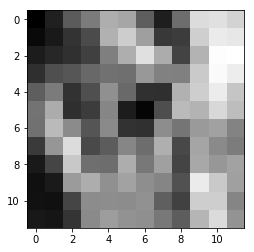

12.882575076073408

 next


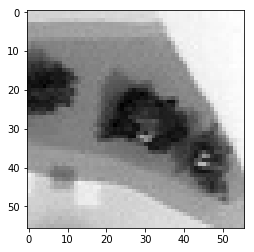

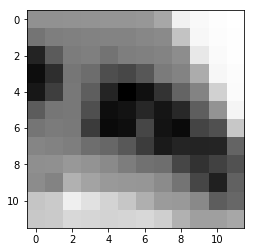

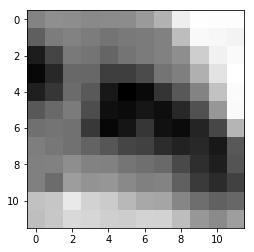

9.771521463990211

 next


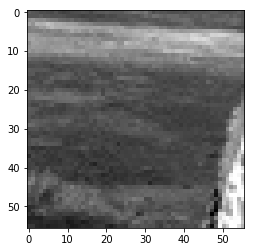

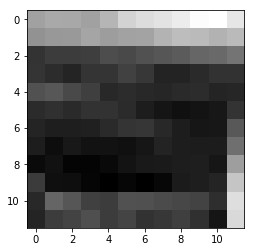

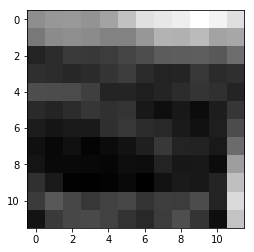

7.960922894999385

 next


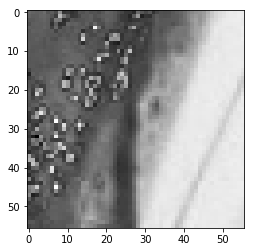

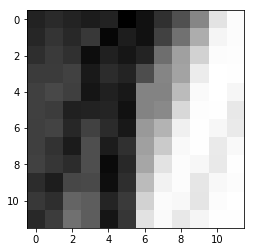

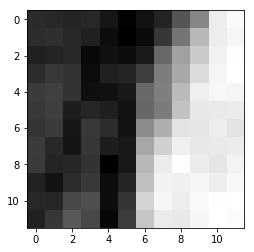

9.367611687630415

 next


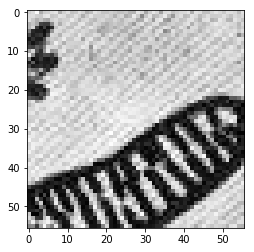

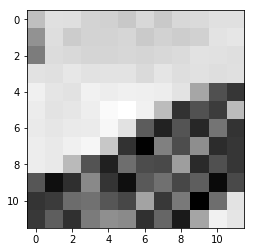

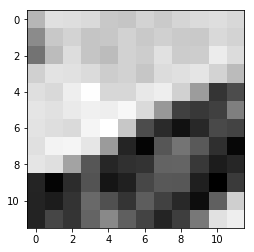

17.681262530386448

 next


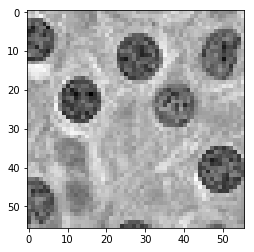

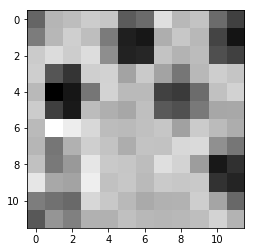

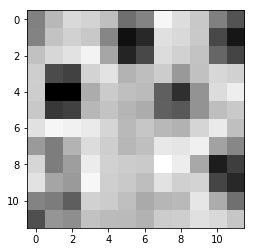

10.777152702212334

 next


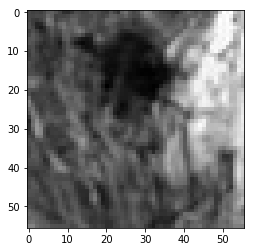

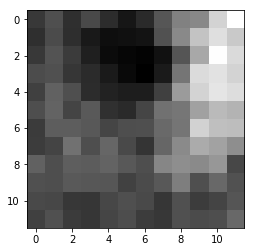

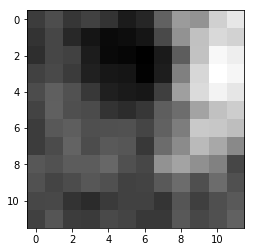

9.824805054813623

 next


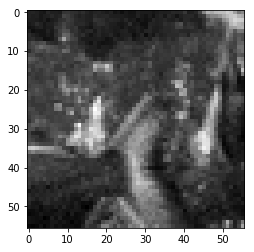

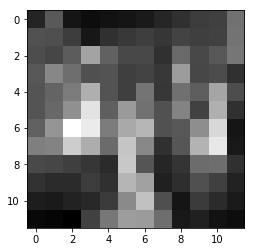

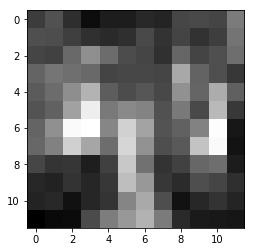

8.742966055870056

 next


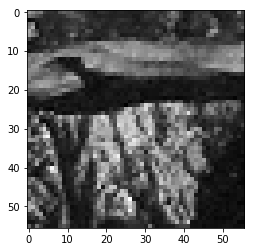

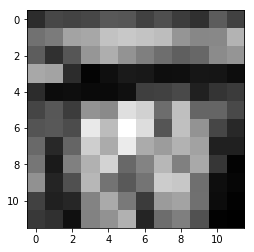

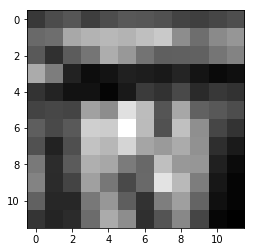

10.532047804445028

 next


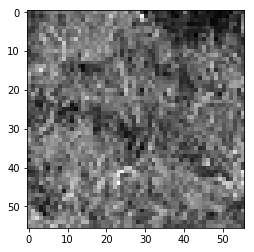

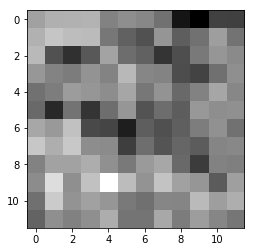

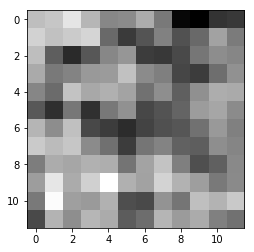

7.802850902080536

 next


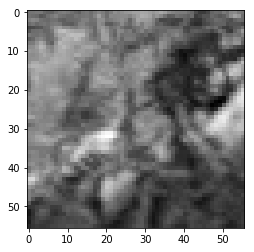

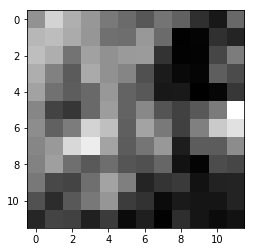

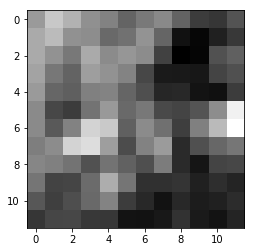

9.436474442481995

 next


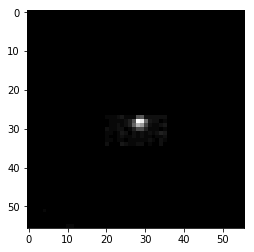

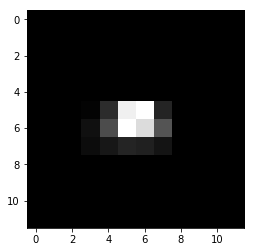

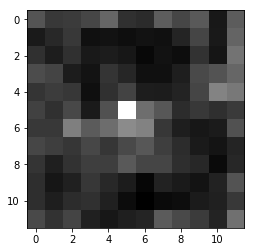

0.7159229088574648

 next


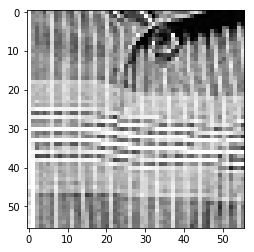

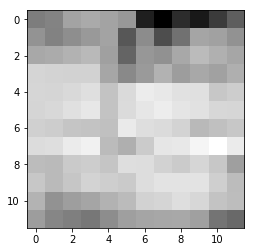

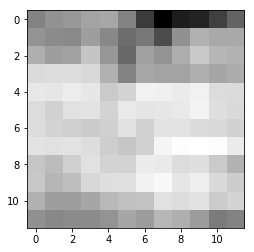

12.257842998951674

 next


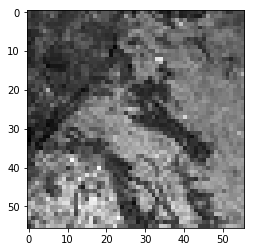

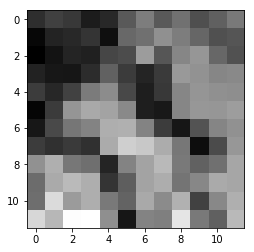

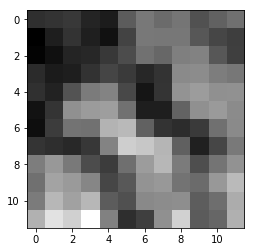

8.109663538634777

 next


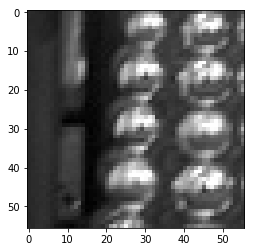

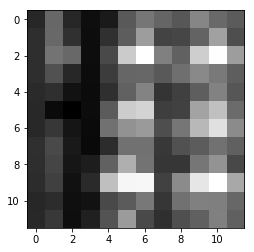

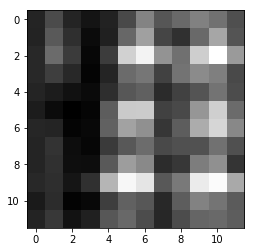

12.087509538978338

 next


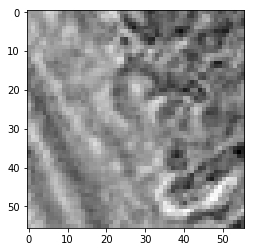

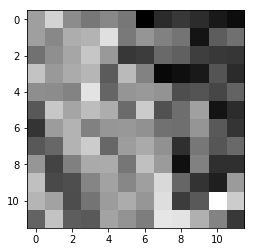

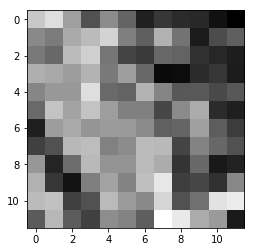

11.820571012794971

 next


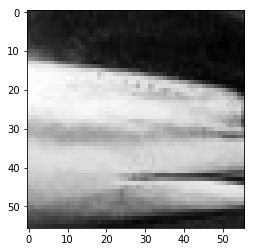

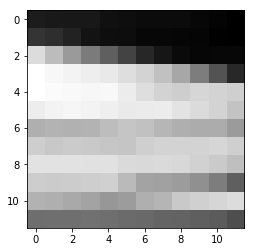

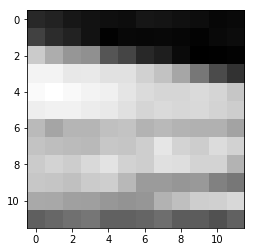

11.986645851284266

 next


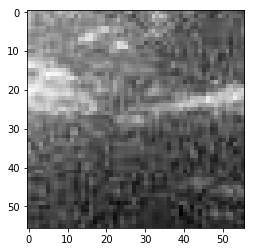

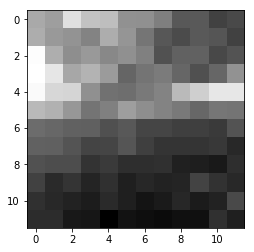

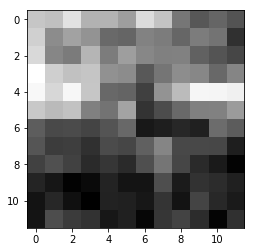

9.254753943532705

 next


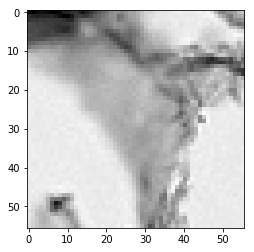

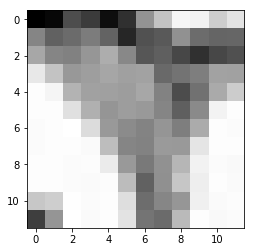

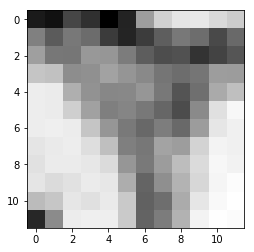

12.137665897607803

 next


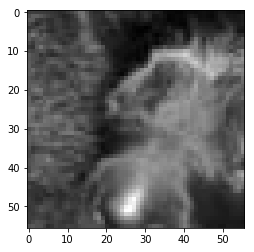

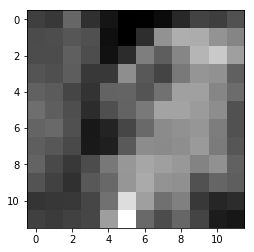

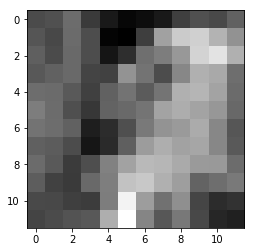

8.784623220562935

 next


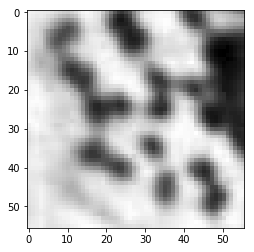

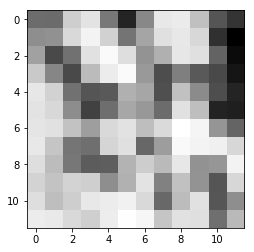

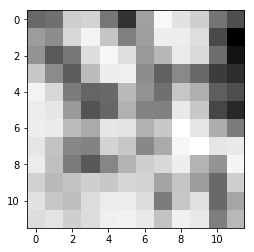

11.707239244133234

 next


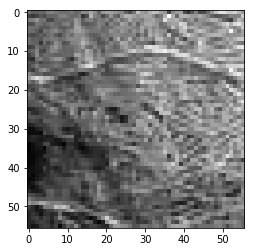

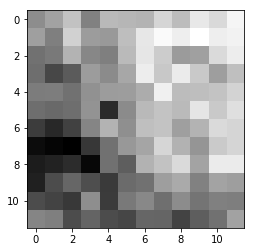

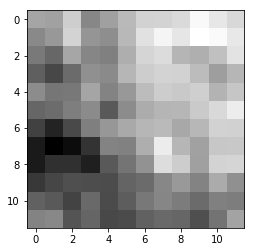

7.71240103058517

 next


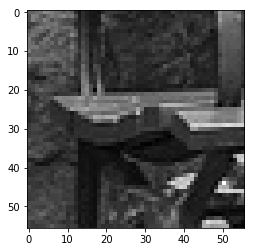

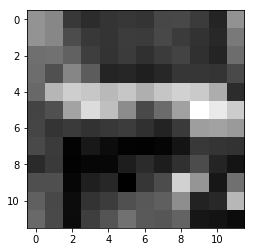

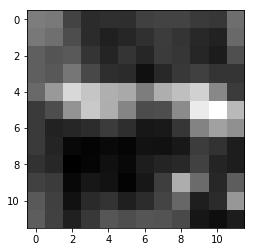

8.559055924415588

 next


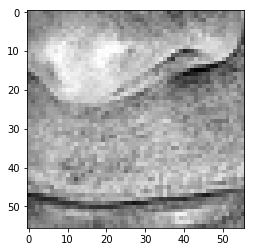

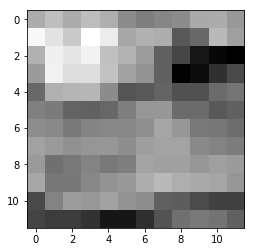

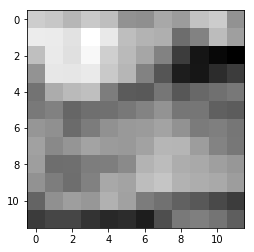

11.986098680645227

 next


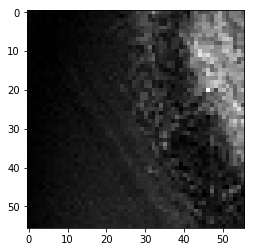

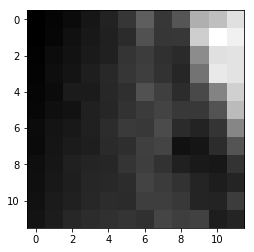

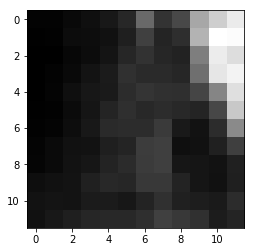

6.73945801332593

 next


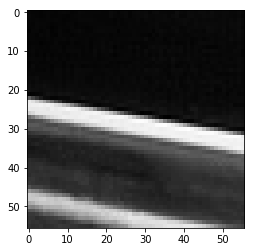

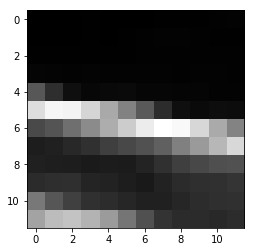

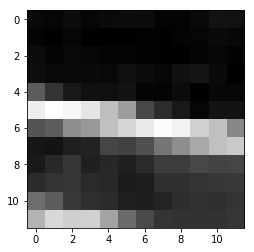

10.269810575991869

 next


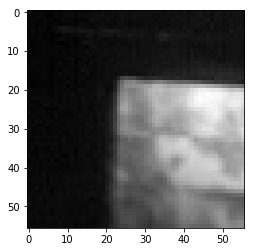

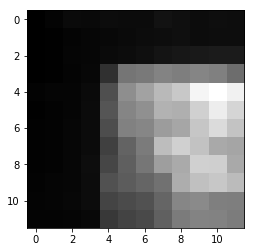

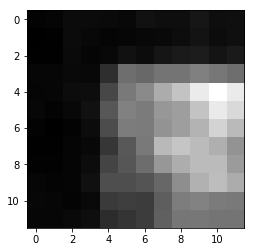

7.49975161626935

 next


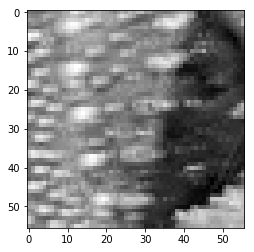

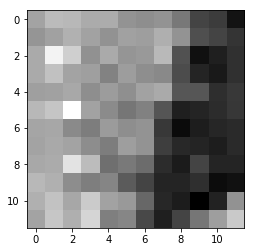

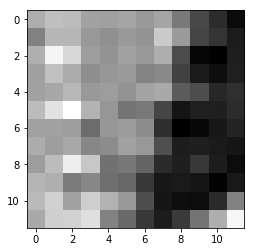

9.561818316578865

 next


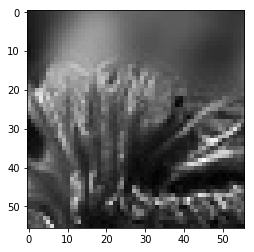

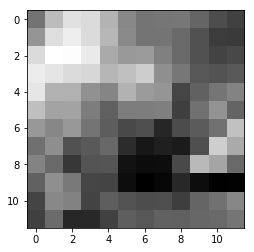

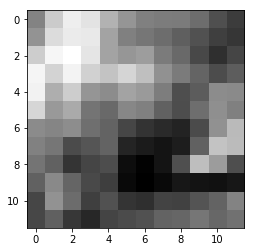

8.591729421168566

 next


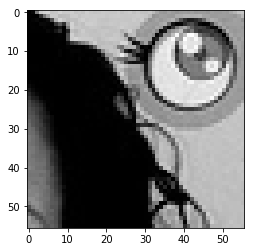

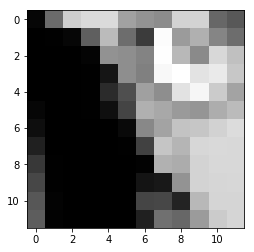

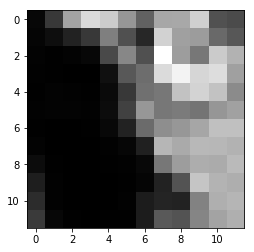

13.182389438152313

 next


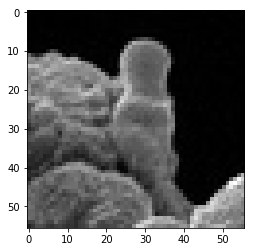

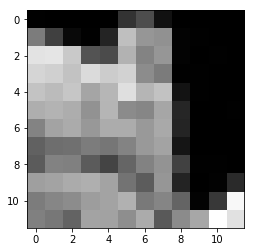

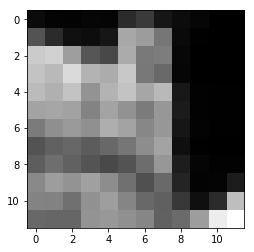

10.799480304121971

 next


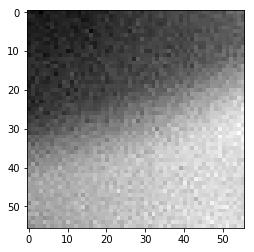

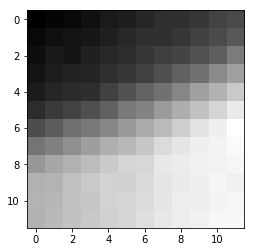

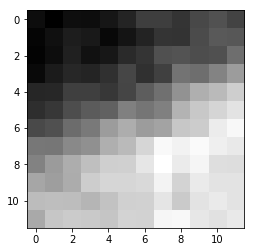

6.5806265361607075

 next


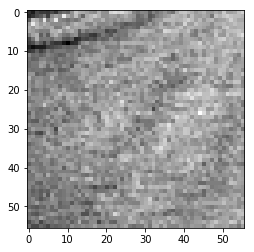

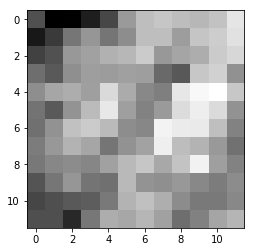

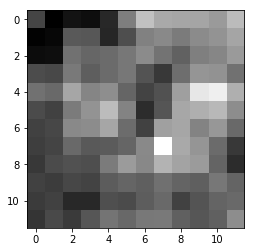

6.628910070285201

 next


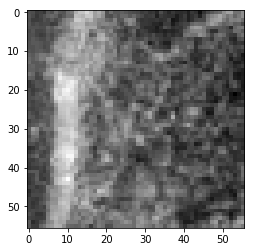

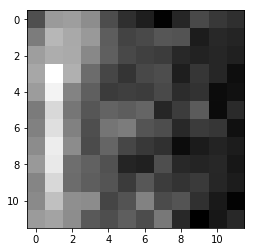

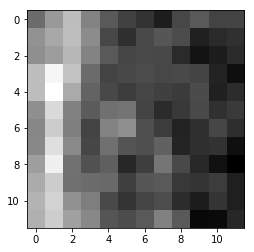

6.987363360822201

 next


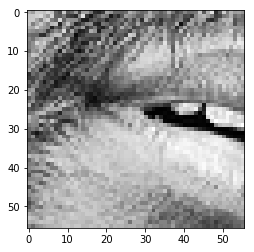

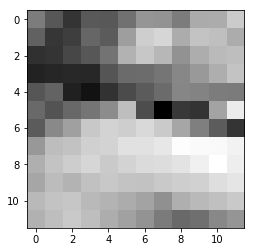

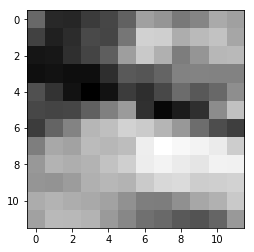

13.719295877963305

 next


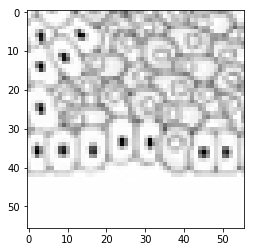

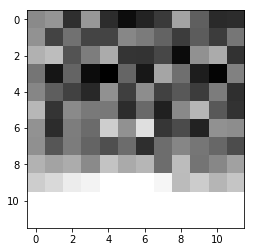

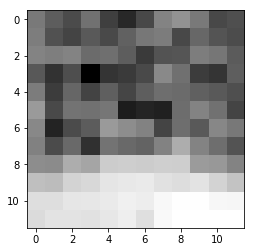

15.078019369393587

 next


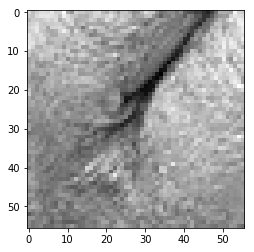

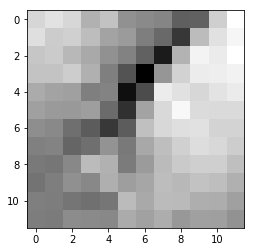

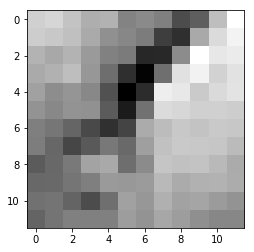

9.549517426639795

 next


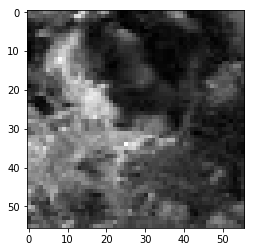

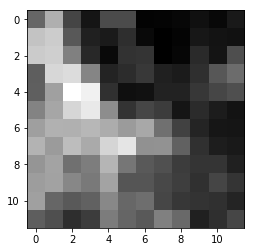

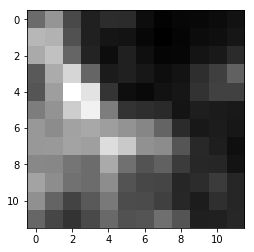

7.588836411014199

 next


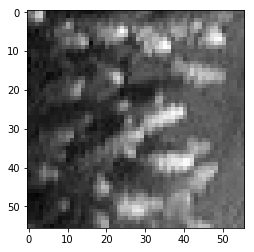

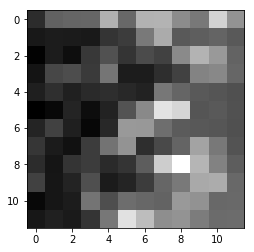

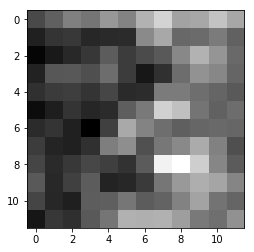

7.187468223273754

 next


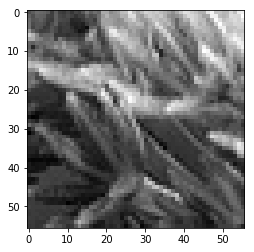

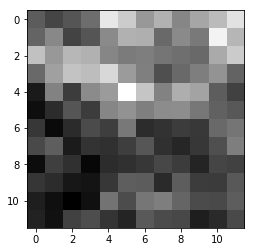

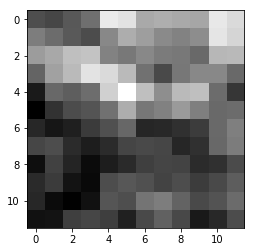

11.977861672639847

 next


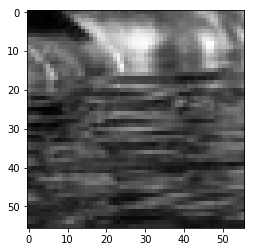

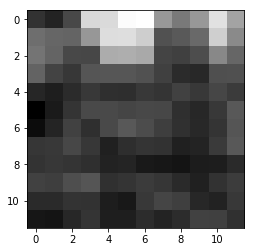

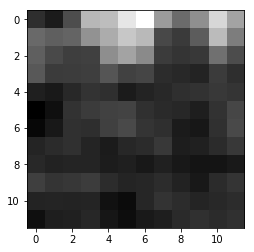

8.100396785885096

 next


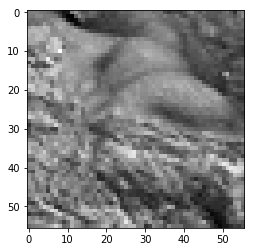

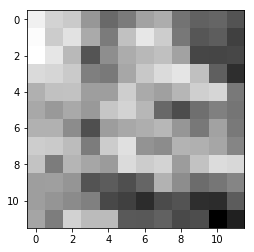

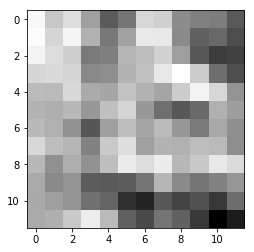

9.463587887585163

 next


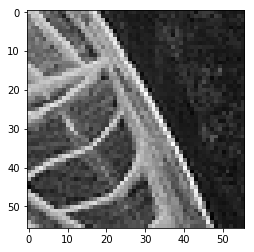

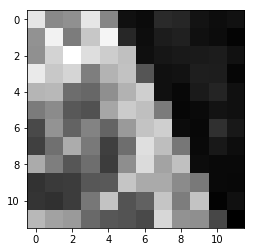

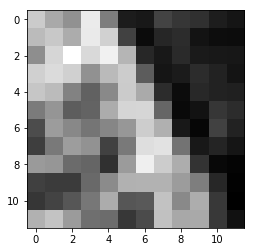

12.249122466892004

 next


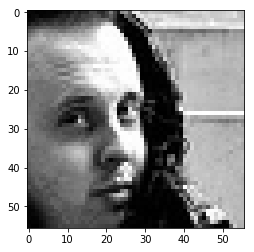

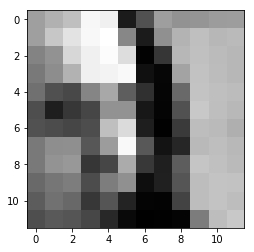

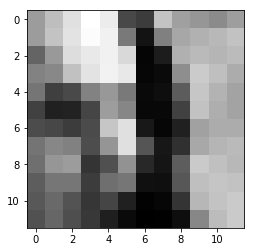

16.39751471579075

 next
0.03939871059730649


In [14]:
images_directory = base_dir + '/test/class0'
files = os.listdir(images_directory)
files.sort()

images = []

counter = 0

for file in files:
    counter += 1
    if counter > 100:
        break
    if not file.startswith('.'):
        #print(file)
        
        img = load_img(images_directory + '/' + file, False, target_size=(input_patch_size, input_patch_size))
        img = imageio.imread(images_directory + '/' + file)
        img = np.expand_dims(img, axis=-1)        
        images.append(img)
        

rmses = 0
        
images = np.array(images).reshape(np.array(images).shape[0], input_shape[0], input_shape[1], input_shape[2])
images = images / 255
predictions = brief_ae.predict_on_batch(np.array(images))
print("predictions: ")
for i, im1 in enumerate(images):
    im_1 = im1.reshape(input_shape)
    plt.imshow(im_1[:, :, 0], cmap='gray')
    plt.show()
    
    
    
    ground_truth = im_1[5: 53, 5: 53, 0]
    ground_truth = block_reduce(ground_truth, (4, 4), func=np.mean)
    plt.imshow(ground_truth[:, :], cmap='gray')
    plt.show()
    
    
    pred_1 = predictions[i].reshape((12, 12))
    plt.imshow(pred_1, cmap='gray')
    plt.show()
    
    rmse = np.sqrt(np.mean(np.square(np.subtract(ground_truth, pred_1, dtype=np.float32))))
    print(rmse * 255)
    rmses += rmse
    
    print("\n next")
    
rmses /= len(images)
print(rmses)

In [23]:
rmses * 255

13.405552665880395